In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from skimage import data, util, exposure, color

# Operadores Puntuales

Los **operadores puntuales** se caracterizan por aplicar una transformación al valor de cada píxel independientemente, sin tener en consideración a los píxeles vecinos. En esto se diferencian de los **operadores locales** que, para transformar el valor de un píxel realizan una operación que incluye a los píxeles vecinos.

Matemáticamente, un operador puntual es una transformación $y_{ij} = T(x_{ij})$ en la que el píxel de salida $y_{ij}$ solo depende de cada píxel de entrada $x_{ij}$, mientras que en un operador puntual la dependencia se extiende a toda una vecindad $N(x_{ij})$ del píxel de entrada.

En este *notebook* nos centraremos en operadores puntuales, y veremos en otro posterior los operadores locales.


## Caracterización estadística. El Histograma

En primera aproximación es conveniente considerar a una imagen monocroma (con un solo canal, por tanto) como la realización de un comjunto de variables aleatorias (VA) independientes e idénticamnete distribuidas (IID), modelando cada VA el valor de intensidad de cada píxel. En una imagen real los píxeles no son idependientes, pues hay dependencia estadística entre ellos y, además, la caracterización probabilística puede ser distinta en distintas zonas de la imagen. Pero el modelo IID es sumamente útil para realizar un análisis estadístico inicial.

Comenzaremos leyendo una imagen en niveles de gris, y obteniendo algunos estadísticos. Podrámos obtener fácilmente todos los vistos en la asignatura de Estadística y Procesos Estocásticos, pero vamos a seleccionar solo algunos de ellos:
- Valores máximo, mínimo y rango (máximo - mínimo)
- Valor medio, desviación típica, varianza y coeficiente de variación
- Primer cuartil (Q1), segundo cuartil (Q2) o mediana, tercer cuartil (Q3), rango intercuartil (IQR) y ra ngo medio intercuartil

Y haremos la habitual representación en el *diagrama de caja y bigote*, recordando que el extremo inferior y superior de los bigotes se calcula restando y sumando $1.5IQR$, respectivamente al primer y tercer cuartil. Esto muestra el límite de los valores atípicos (el valor 1.5 podría cambiarse dependiendo de los datos).

C:\Users\javie\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Tipo de datos:  uint8
Tamaño de imagen (filas, columnas):  (512, 512)
Númro de píxels:  262144


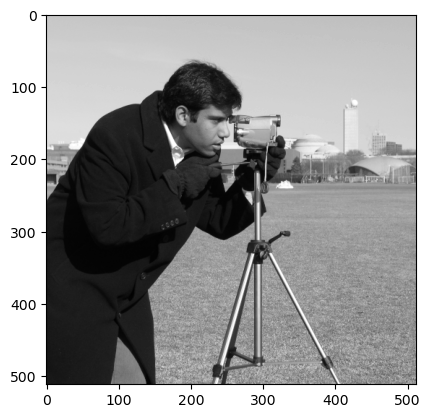

In [2]:
img = data.camera()
print('Tipo de datos: ', img.dtype)
print('Tamaño de imagen (filas, columnas): ', img.shape)
print('Númro de píxels: ', img.size)
plt.imshow(img,cmap='gray');

In [3]:
print('Mímimo: ', img.min(), '\tMáximo: ', img.max(), '\tRango: ', img.max()-img.min())
print('Media: ', img.mean(), '\tDesviación típica: ', img.std(), '\tVarianza: ', img.var(), 
      '\nCoeficiente de variación', img.std()/img.mean(), )

Mímimo:  0 	Máximo:  255 	Rango:  255
Media:  129.06072616577148 	Desviación típica:  73.64484655630548 	Varianza:  5423.563424301779 
Coeficiente de variación 0.5706216658173199


In [4]:
img_q = np.quantile(img, (0.25, 0.5, 0.75))
print('1er cuantil (Q1): ', img_q[0], '\tMediana (Q2): ', img_q[1], '\t3er cuantil (Q3): ', img_q[2],
     '\nRango intercuantil (IQR): ', img_q[2]-img_q[0], '\tRango medio intercuantil: ', (img_q[0]+img_q[2])/2,
     '\nBigote inferior (Q1 - 1.5 IQR): ', (img_q[0]*1.5)-(img_q[2]-img_q[0]),
     '\nBigote superior (Q3 + 1.5 IQR): ', (img_q[2]*1.5)+(img_q[2]-img_q[0]))

1er cuantil (Q1):  35.0 	Mediana (Q2):  152.0 	3er cuantil (Q3):  197.0 
Rango intercuantil (IQR):  162.0 	Rango medio intercuantil:  116.0 
Bigote inferior (Q1 - 1.5 IQR):  -109.5 
Bigote superior (Q3 + 1.5 IQR):  457.5


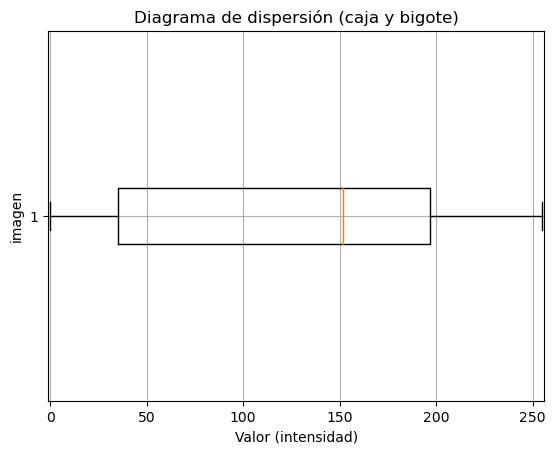

In [3]:
plt.boxplot(img.flatten(), vert=False)
plt.xlim([-1, 256])
plt.title('Diagrama de dispersión (caja y bigote)')
plt.xlabel('Valor (intensidad)')
plt.ylabel('imagen')

plt.grid()

Representamos ahora el histograma mediantes las frecuencias de aparición de cada valor de intensidad discreto. Estas frecuencias pueden ser absolutas (número de veces que se repite cada nivel) o relativas (la frecuencia abosluta, dividida por el número de píxels.

Utilizamos la función de [histograma de scikit-image](https://scikit-image.org/docs/stable/api/skimage.exposure.html#histogram), si bien Numpy y otros paquetes también proporcionan funciones para su representación.

Valor mínimo:  0 	Valor máximo:  255


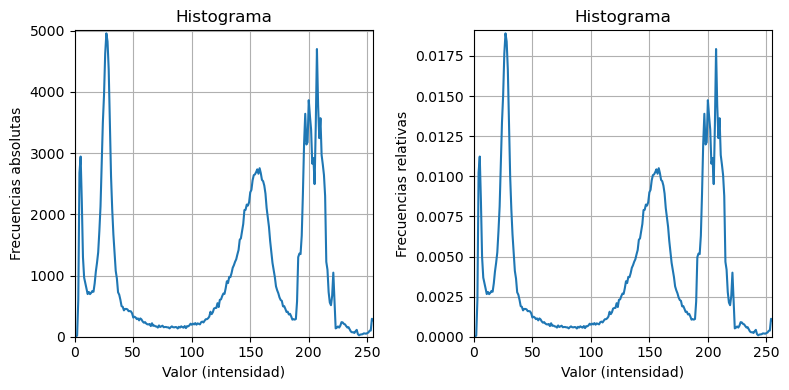

In [4]:
plt.figure(figsize=(8, 4))


img_hist, bins = exposure.histogram(img, normalize=False)
plt.subplot(121)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias absolutas')
plt.grid()


img_hist, bins = exposure.histogram(img, normalize=True)

plt.subplot(122)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

print('Valor mínimo: ', img.min(), '\tValor máximo: ', img.max())

Podemos también obtener la fucnión de distribución cumulativa, esto es, el la función que describe las frecuencias relativas acumuladas hasta un valor dado. Recuérdese que esta función está directamente relacionada con el histograma (se obtiene acumulando las sucesivas frecuencias relativas), y aproxima la función de distribución de probabilidad de los valores obtenidos en la realización. 

Recuérdesse también que para obtener la distribución a partir del histgrama debemos acumular los valores de éste y, al contrario, para obtener el histograma a partir de la distribución debemos de realizar diferecnias sucesivas.

En todo caso, este trabajo de cálculo se lo dejamos a la función [cumulative_ditribution()](https://scikit-image.org/docs/stable/api/skimage.exposure.html#cumulative-distribution) de scikit-image.

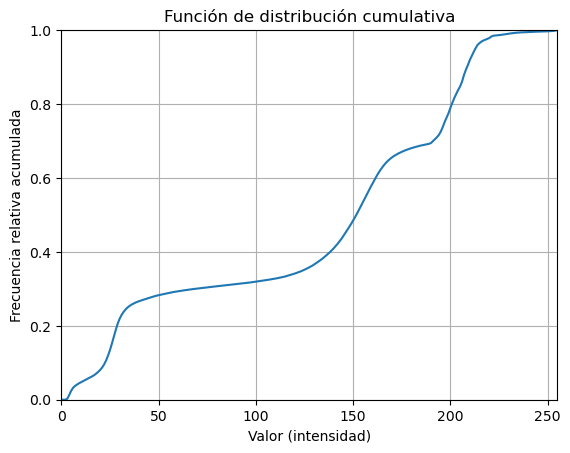

In [5]:
img_cdf, bins_cdf = exposure.cumulative_distribution(img)

plt.plot(bins_cdf, img_cdf)
plt.axis([0,255, 0, 1])
plt.title('Función de distribución cumulativa')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencia relativa acumulada')
plt.grid()

## Imágenes en color

Cuando tenemos imágenes en color trabajamos por separado con sus canales componentes. Por ejemplo, podemos trabajar directamente sobre los canales RGB (rojo, verde y azul) o, alternativamente, por ejemplo, hacerlo sobre los canales HSV (tinte, saturación y valor).

El [módulo de color de scikit-image](https://scikit-image.org/docs/stable/api/skimage.color.html) tiene muchas funciones para transformar espacios de color, incluyendo todos los habituales. 

Veamos primero cómo trabajar sobre los canales RGB.

Tipo de datos:  uint8
Tamaño de imagen (filas, columnas):  (400, 600, 3)
Númro de píxels:  720000


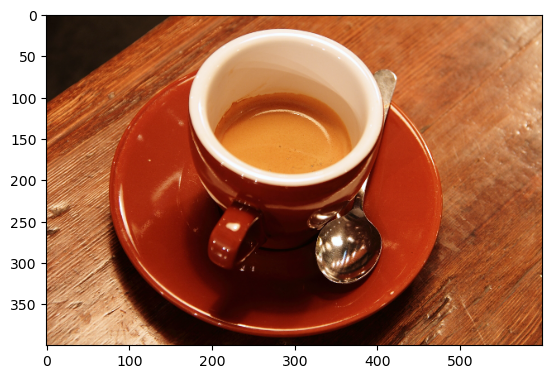

In [6]:
img_RGB = data.coffee()
print('Tipo de datos: ', img_RGB.dtype)
print('Tamaño de imagen (filas, columnas): ', img_RGB.shape)
print('Númro de píxels: ', img_RGB.size)
plt.imshow(img_RGB);

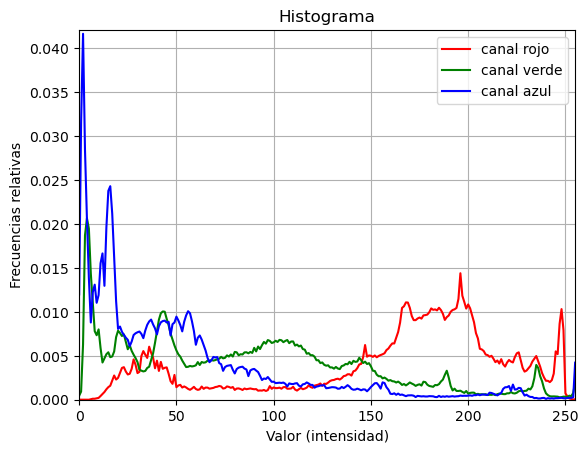

In [7]:
img_hist, bins = exposure.histogram(img_RGB, channel_axis=2, normalize=True)
M = img_hist.max()

plt.plot(bins, img_hist[0,:],'r', label='canal rojo')
plt.plot(bins, img_hist[1,:],'g', label='canal verde')
plt.plot(bins, img_hist[2,:],'b', label='canal azul')

plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.legend()
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

Veamos ahora cómo trabajar sobre el espacio HSV. La imagen en el espacio HSV no se puede representar directamente (hay que convertirla a RGB) y está en punto flotante, en el rango 0 a 1. 

- Hue (tinte o color): varía de 0 a 360º, pero se normaliza de 0 a 1. 0ª y 360ª (ó 0) es rojo, 120º (o 1/3) es verde y 240ª (2/3) es azul
- Saturation (saturación): 0 no está saturado (blanco o gris, sin color) y 1 completamente saturado (color puro)
- Value (valor o intensidad percibida -luma-): 0 es mínima luma y 1 es máxima

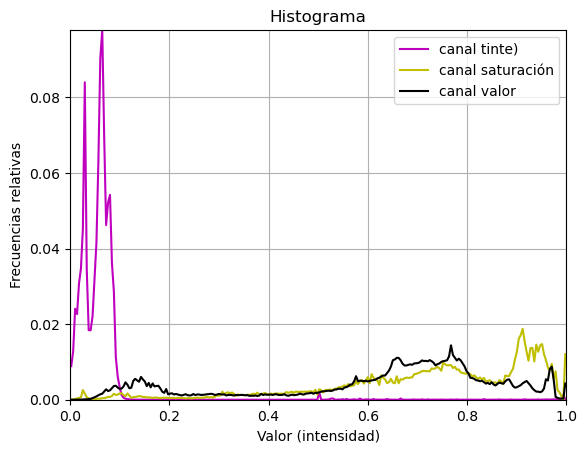

In [17]:
img_hsv = color.rgb2hsv(img_RGB)

img_hist, bins = exposure.histogram(img_hsv, channel_axis=2, normalize=True)

plt.plot(bins, img_hist[0,:],'m', label='canal tinte)')
plt.plot(bins, img_hist[1,:],'y', label='canal saturación')
plt.plot(bins, img_hist[2,:],'k', label='canal valor')

plt.axis([0,1, 0, img_hist.max()])
plt.legend()
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()



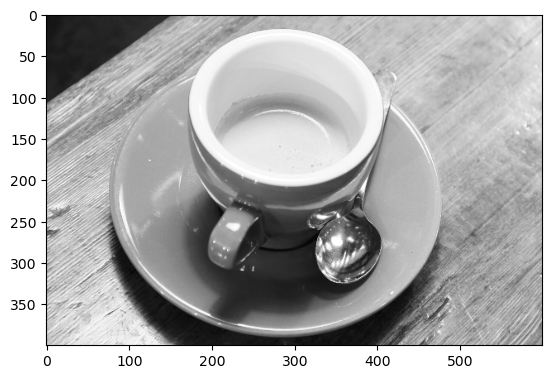

In [24]:
#Vamos a pasar la imagen a hsv para poner la saturación a 0 y verla en blanco y negro
img_hsv2 = img_hsv.copy() #Copiamos la imagen para no perder al anterior

img_hsv2[:, :, 1] = 0 #Ponemos la columna de la saturación a 0, partiendo de que arriba es 1 el canal de saturación
img_RGB2 = color.hsv2rgb(img_hsv2) #Lo volvemos a transformar a RGB 
plt.imshow(img_RGB2); #Mostramos la imagen

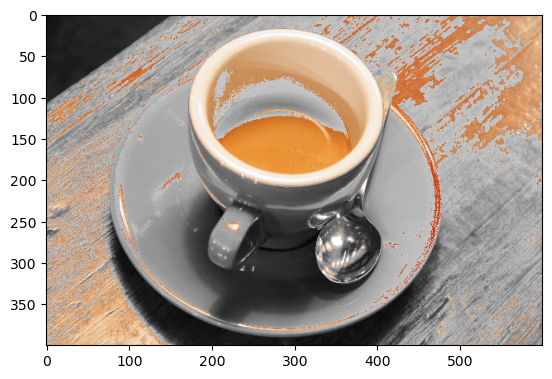

In [32]:
mask = img_RGB[:,:,0] < 200
plt.imshow(mask, cmap='gray')

img_hsv2 = img_hsv.copy()
img_hsv2[mask,1] = 0
img_RGB2 = color.hsv2rgb(img_hsv2)
plt.imshow(img_RGB2);

## Modificando el brillo y el contraste de la imagen

Los términos *brillo* y *contraste* provienen de los tiempos de los primeros receptores comerciales de televisión, y son ambiguos en cuanto a las características perceptuales que describen (realmente actuaban directamente sobre la deriva y la ganancia del tubo de rayos catódico). Nosotros vamos a utilizar los **niveles de negro y de blanco** o, alternativamente, el **nivel y la ventana**.

En cualquier caso, se trata de transformar cada uno de los píxeles de la imagen lineamente, conforme a una ecuación de recta genérica, con objeto de mejorar la percepción alterando lo que intuitivamente podemos entender por brillo y contraste: 
$$ y = mx + b$$
donde $x$ e $y$ son, respectivamente, los valores del píxel antes y después de aplicar la transformación.

$y = 0$ fija el **nivel de negro** ($B_L$), mientras que $y = M_i$ (máximo valor posible, por ejemplo, 255) fija el **nivel de blanco** ($W_L$) de los píxeles de entrada. Si $x <0$ se fija 0 y si $x > M_i$ se fijan 0 y $M_i$ para los niveles de negro y blanco, respectivamente.

El **nivel** ($L$) es el punto medio entre los niveles de negro y blanco, mientras que la **ventana** ($W$) es la distancia entre los niveles de negro y blanco. Podemos considerar que *el brillo corresponde al nivel, mientras que el contrate corresponde a la ventana*.

Podemos ver fácilmente las relaciones matemáticas entre los parámetros mencionados. Así pues, el nivel y la ventana podemos expresarlos en función de los niveles de negro y blanco:

$$ L = \frac{B_L+W_L}{2}$$
$$ W = W_L - B_L$$

Y, viceversa:

$$B_L = L - \frac{W}{2}$$
$$W_L = L + \frac{W}{2}$$

Y la pendiente y ordenada en el origen de la recta son:
$$ m = \frac{M_i}{W_L - B_L} = \frac{M_i}{W}$$
$$b = -\frac{M_i B_L}{W_L - B_L} =- M_i (\frac{L}{W}-\frac{1}{2})$$

Veamos una imagen en niveles de gris. El rango de valores está relativamente concentrado, por lo que podemos decir que el contraste es bajo. **El contraste es el rango intercuantil dividido por el rango de valores posibles de la imagen**.  Consideraremos que el contraste es bajo cuando dicha razón esté por debajo de un umbral.

Adviértase que el contraste se refiere según esta definición a los valores extremos, sin considerar que pudiera no haber contraste entre valores intermedios.

scikit-image tiene la función *is_low_contrast()*, en la cual se puede proporcionar los cuantiles para el rango (por defecto entre el percentil y y el 99) y el unbral para determinar si la imagen es de bajo contraste.

In [11]:
img = data.microaneurysms()
print('Tipo de datos: ', img.dtype)
print('Tamaño de imagen (filas, columnas): ', img.shape)
print('Número de píxels: ', img.size)
print('Imagen: \nValor mínimo: ', img.min(), '\tValor máximo: ', img.max())
print('Valor mediano: ', img.mean())

Tipo de datos:  uint8
Tamaño de imagen (filas, columnas):  (102, 102)
Número de píxels:  10404
Imagen: 
Valor mínimo:  38 	Valor máximo:  129
Valor mediano:  99.33986928104575


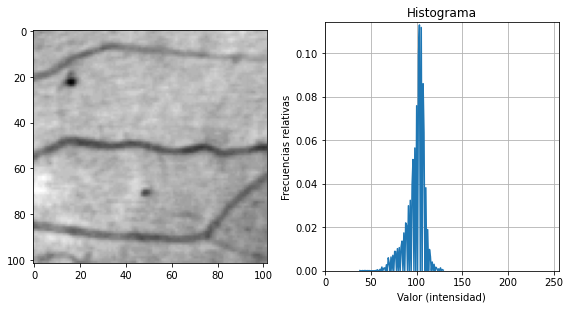

In [12]:
img_hist, bins = exposure.histogram(img, normalize=True)

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.imshow(img, cmap='gray')

plt.subplot(222)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

Como se ve en el histograma y se percibe en la imagen, el contraste es relativamente pequeño, como podemos comprobar con el test (unmbral de bajo contraste fijado en utilizar al menos el 20% del rango dinámico de la imagen) 

In [13]:
exposure.is_low_contrast(img,  fraction_threshold=0.2)

True

Definamos una transformación lineal para modificar puntialmente la imagen.

In [14]:
# Definición de la transformación

Mi = 255

Bl = 60
Wl = 129

L = (Bl + Wl)/2
W = Wl - Bl

#L = 128
#W = 256

#Bl = L - W/2
#Wl = L + W/2

m = Mi/W
b = -Mi*(L/W - 0.5)

print('Nivel (L): ', L, '\tVentana (W): ', W)
print('Nivel de negro: ', Bl, '\tNivel de Blanco: ', Wl)
print('m = ', m, 'b = ', b)


Nivel (L):  94.5 	Ventana (W):  69
Nivel de negro:  60 	Nivel de Blanco:  129
m =  3.6956521739130435 b =  -221.73913043478262


Representemos ahora la transformación.

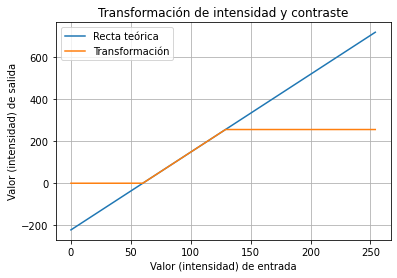

In [15]:

# Representación de la transformación

x = np.arange((min(Bl, 0)), max(Wl, Mi))
y = m*x +b

y_transf = y.copy()
y_transf[y_transf<0] = 0
y_transf[y_transf>Mi] = Mi

plt.plot(x,y, label='Recta teórica')
plt.plot(x, y_transf, label='Transformación')

plt.legend()
plt.title('Transformación de intensidad y contraste')
plt.xlabel('Valor (intensidad) de entrada')
plt.ylabel('Valor (intensidad) de salida')
plt.grid()

Para evitar perder precisión, las operaciones las hacemos en punto flotante. Pero tenemos que hacer las conversiones desde entero a punto flotante y, una vez hecha la transformación, de punto flotante a entero. La conversión de tipos podemos hacerla de dos maneras:
- Con el método [astype()](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html?highlight=astype#numpy.ndarray.astype) de los *ndarrays* de Numpy, que generan un nuevo ndarray con el [dtype](https://numpy.org/doc/stable/reference/arrays.scalars.html) que se indique.
- Con las funciones *img_as_TIPO()* del módulo *util* de *skit-image*. En estgos caso no solo se hace la conversión del tipo, sino que se reescalan los datos:
    - ubyte y uint: sin signo, de 8 ó 16 bits, respectivamente. Esto es, rango de 0 a 255 ó a 65535
    - int: entero de 16 bits con signo, esto es, de -32768 hasta 32767. Pero si la imagen de entrada solo tiene valores positivos, el resultado solo tendrá enteros positivos
    - float32 y float64 (o simplemente float): flotante en precisión simple y doble, respectivamente. El rango es \[0, 1\] ó \[-1, 1\] según se convierta de un tipo entero sin signo o con signo. Si se convierte de otro tipo flotante, no se reescala y los valores podrían quedar fuera del rango mencionado
    - bool: booleano

Utilizaremos ahora la función de scikit-image.util para hacer la conversión, **por lo que tendremos que tener en cuenta el reescalado**.

In [16]:
img_float = util.img_as_float(img)*Mi

img_float = img_float*m + b
img_float[img_float<0]  = 0
img_float[img_float>Mi] = Mi

img_transf = util.img_as_ubyte(img_float/Mi)

print('Tipo de datos: ', img_transf.dtype)
print('Tamaño de imagen (filas, columnas): ', img_transf.shape)
print('Número de píxels: ', img_transf.size)
print('Imagen: \nValor mínimo: ', img_transf.min(), '\tValor máximo: ', img_transf.max())
print('Valor mediano: ', img_transf.mean())

Tipo de datos:  uint8
Tamaño de imagen (filas, columnas):  (102, 102)
Número de píxels:  10404
Imagen: 
Valor mínimo:  0 	Valor máximo:  255
Valor mediano:  145.36918492887352


La transformación aumenta el contraste de la imagen. Prueba a variar los parámteros de la misma para quye obtengas intuición.

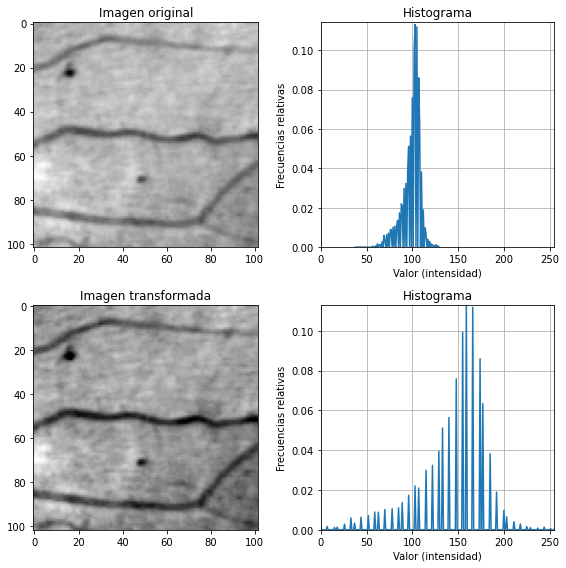

In [17]:
img_hist, bins = exposure.histogram(img, normalize=True)

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.imshow(img, cmap='gray')
plt.title('Imagen original')

plt.subplot(222)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()


img_hist, bins = exposure.histogram(img_transf, normalize=True)

plt.subplot(223)
plt.imshow(img_transf, cmap='gray')
plt.title('Imagen transformada')

plt.subplot(224)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

Veamos ahora una secuencia de imágenes de TAC del cráneo y veamos si podemos mejorarlas para su visualización.

Adviértase que siempre debemos ver el tipo de datos (en este caso tienen 16 bits de profundidad), y tenerlo en cuento para la transformación (ahora el rango posible de valores es de 0 a 65535).

Véase que utilizamos una escala logarítimica en el eje $y$ para represnter el histograma.

Tipo:  uint16
mín:  0 	máx:  51076


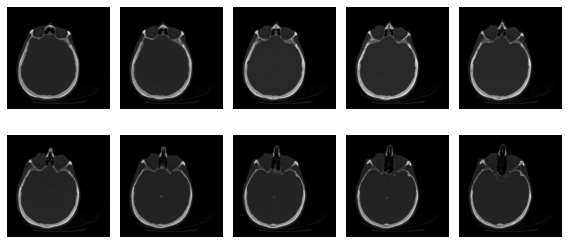

In [18]:
images = data.brain()
print('Tipo: ', images.dtype)
print('mín: ', images.min(), '\tmáx: ', images.max())

fig, axes = plt.subplots(2, 5, figsize=(8, 4))
ax = axes.ravel()

for i in range(images.shape[0]):
    ax[i].imshow(images[i], cmap=plt.cm.gray)
    ax[i].axis('off')
fig.tight_layout()
plt.show()


El contraste de estas imágenes es alto, pues tenemos píxeles brillantes en el cráneo y muy oscuros en todos los tejidos blancos, como dentro del cerebro. Sin embargo dentro del cerebro no hay contraste.

Para representar el histograma utiizamos una escla logarítmica en el eje y.

Valor mínimo:  38 	Valor máximo:  129


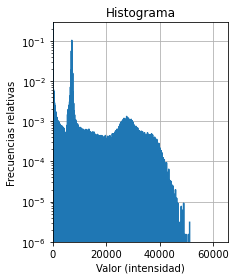

In [19]:
img_hist, bins = exposure.histogram(images, normalize=True)
plt.subplot(122)
plt.plot(bins, img_hist)
plt.yscale('log')
plt.axis([0,2**16-1, 10**(-6), img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

print('Valor mínimo: ', img.min(), '\tValor máximo: ', img.max())

Ahora definimos y representamos la transformación.

Nivel (L):  8000.0 	Ventana (W):  14000
Nivel de negro:  1000 	Nivel de Blanco:  15000
m =  4.681071428571428 b =  -4681.071428571427


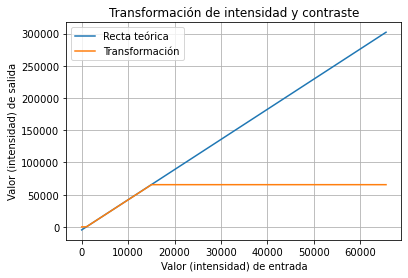

In [20]:
# Definición de la transformación

Mi = 2**16-1

Bl = 1000
Wl = 15000

L = (Bl + Wl)/2
W = Wl - Bl

#L = 128
#W = 256

#Bl = L - W/2
#Wl = L + W/2

m = Mi/W
b = -Mi*(L/W - 0.5)

print('Nivel (L): ', L, '\tVentana (W): ', W)
print('Nivel de negro: ', Bl, '\tNivel de Blanco: ', Wl)
print('m = ', m, 'b = ', b)


# Representación de la transformación

x = np.arange((min(Bl, 0)), max(Wl, Mi))
y = m*x +b

y_transf = y.copy()
y_transf[y_transf<0] = 0
y_transf[y_transf>Mi] = Mi

plt.plot(x,y, label='Recta teórica')
plt.plot(x, y_transf, label='Transformación')

plt.legend()
plt.title('Transformación de intensidad y contraste')
plt.xlabel('Valor (intensidad) de entrada')
plt.ylabel('Valor (intensidad) de salida')
plt.grid()

La transformación mejora la percepción visual de las imágenes, si bien sigue sin apreciarse contraste debtro del cerebro, pero queda mucho mejor separado del fondo. Prueba a variar los parámteros de la misma para quye obtengas intuición.

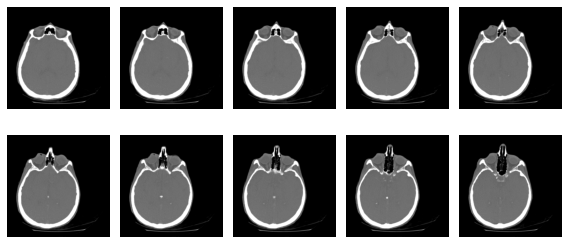

In [21]:
images_float = util.img_as_float(images)*Mi

images_float = images_float*m + b
images_float[images_float<0]  = 0
images_float[images_float>Mi] = Mi

images_transf = util.img_as_uint(images_float/Mi)


fig, axes = plt.subplots(2, 5, figsize=(8, 4))
ax = axes.ravel()

for i in range(images_transf.shape[0]):
    ax[i].imshow(images_transf[i], cmap=plt.cm.gray)
    ax[i].axis('off')
fig.tight_layout()
plt.show()

Valor mínimo:  38 	Valor máximo:  129


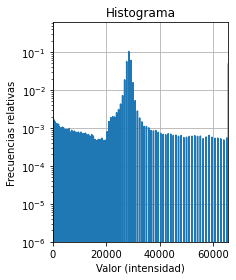

In [22]:
img_hist, bins = exposure.histogram(images_transf, normalize=True)
plt.subplot(122)
plt.plot(bins, img_hist)
plt.yscale('log')
plt.axis([0,2**16-1, 10**(-6), img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

print('Valor mínimo: ', img.min(), '\tValor máximo: ', img.max())

### Función de reescalado de intensidad en scikit-image

https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.rescale_intensity

Veamos un ejemplo. Puedes hacer pruebas cambiaando las imágenes y los parámetros.

Comenzaremos rehaciendo el ejemplo anterior con una nueva imagen y, al final, replicaremos el resultado con la función de reescalado de *scikit-image*.

Tipo de datos:  uint8
Tamaño de imagen (filas, columnas):  (2019, 1826)
Númro de píxels:  3686694
Valor mínimo:  1 	Valor máximo:  255


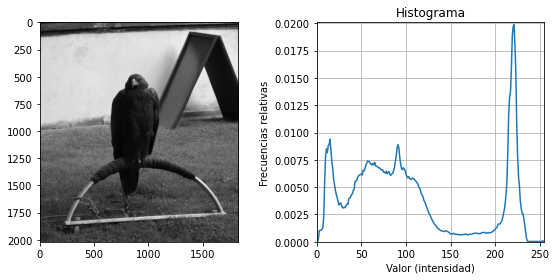

In [23]:
img = data.eagle()
print('Tipo de datos: ', img.dtype)
print('Tamaño de imagen (filas, columnas): ', img.shape)
print('Númro de píxels: ', img.size)
print('Valor mínimo: ', img.min(), '\tValor máximo: ', img.max())

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(img,cmap='gray')


img_hist, bins = exposure.histogram(img, normalize=True)
plt.subplot(122)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

Nivel (L):  75.0 	Ventana (W):  150
Nivel de negro:  0 	Nivel de Blanco:  150
m =  1.7 b =  -0.0


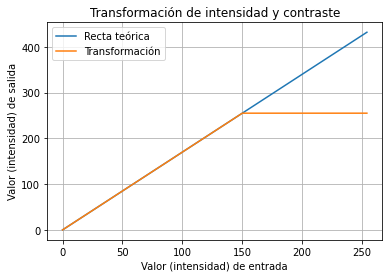

In [24]:
# Definición de la transformación

Mi = 255

Bl = 0
Wl = 150

L = (Bl + Wl)/2
W = Wl - Bl

#L = 128
#W = 256

#Bl = L - W/2
#Wl = L + W/2

m = Mi/W
b = -Mi*(L/W - 0.5)

print('Nivel (L): ', L, '\tVentana (W): ', W)
print('Nivel de negro: ', Bl, '\tNivel de Blanco: ', Wl)
print('m = ', m, 'b = ', b)

# Representación de la transformación

x = np.arange((min(Bl, 0)), max(Wl, Mi))
y = m*x +b

y_transf = y.copy()
y_transf[y_transf<0] = 0
y_transf[y_transf>Mi] = Mi

plt.plot(x,y, label='Recta teórica')
plt.plot(x, y_transf, label='Transformación')

plt.legend()
plt.title('Transformación de intensidad y contraste')
plt.xlabel('Valor (intensidad) de entrada')
plt.ylabel('Valor (intensidad) de salida')
plt.grid()

En este caso utilizamos para la conversión el método astype() de los ndarrays, así que **no necesitamos hacer un reescalado**, a diferencia del ejemplo anterior en que utilizamos la función de conversión de scikit-image.  

In [25]:
img_float = img.astype(float)

img_float = img_float*m + b
img_float[img_float<0]  = 0
img_float[img_float>Mi] = Mi

img_transf = img_float.astype('uint8')

¡Advierte cómo varía el histograma!

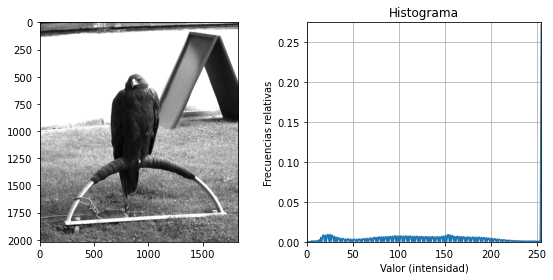

In [26]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(img_transf,cmap='gray')

img_hist, bins = exposure.histogram(img_transf, normalize=True)
plt.subplot(122)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

Ontenemos ahora el mismo resultado con la función de reescalado de *scikit-image*.

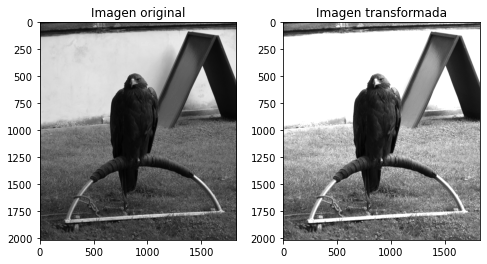

In [27]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.title('Imagen original')

plt.subplot(122)
plt.imshow(exposure.rescale_intensity(img, (0, 150),(0, 255)),cmap='gray')
plt.title('Imagen transformada');

Como vemos, al aplicar la transformación podemos mejorar el contraste del cuerpo del águila, pero perdemos el del muro. Podemos combinar varias transformaciones para mejorar el resultado. Es importante que intentes comprender qué está pasando y que hagas pruebas para ganar intuición.

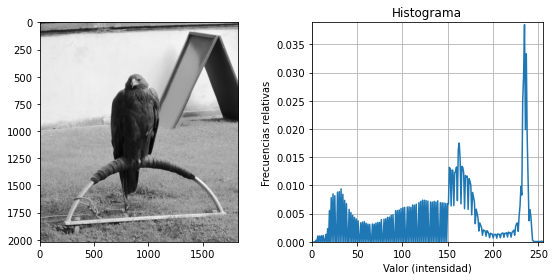

In [28]:
img_1 = exposure.rescale_intensity(img, (0, 70),(0, 150)) 
img_2 = exposure.rescale_intensity(img, (71, 255),(151, 255))


img_transf = (img<=70)*img_1 + (img>=71)*img_2

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(img_transf,cmap='gray')

img_hist, bins = exposure.histogram(img_transf, normalize=True)
plt.subplot(122)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

## Otras transformaciones de la intensidad

### Inversión (negativo)

Tipo de datos:  uint8
Tamaño de imagen (filas, columnas):  (102, 102)
Númro de píxels:  10404
Imagen: 
Valor mínimo:  38 	Valor máximo:  129
Imagen inversa: 
Valor mínimo:  126 	Valor máximo:  217


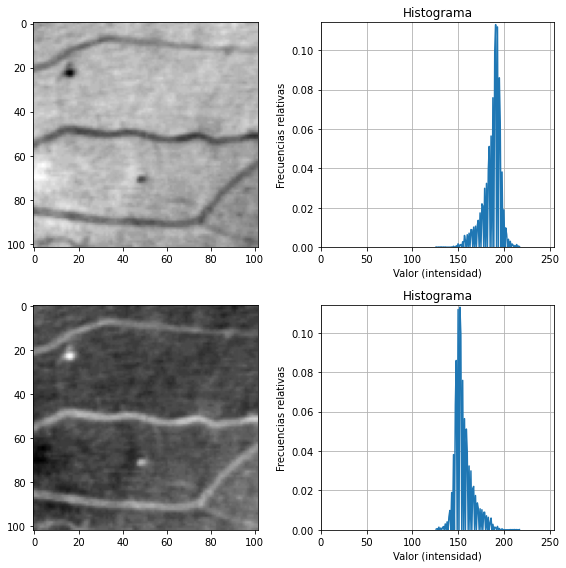

In [29]:
img = data.microaneurysms()
img_inv = util.invert(img)
print('Tipo de datos: ', img.dtype)
print('Tamaño de imagen (filas, columnas): ', img.shape)
print('Númro de píxels: ', img.size)
print('Imagen: \nValor mínimo: ', img.min(), '\tValor máximo: ', img.max())
print('Imagen inversa: \nValor mínimo: ', img_inv.min(), '\tValor máximo: ', img_inv.max())

img_hist, bins = exposure.histogram(img, normalize=True)
img_inv_hist, bins = exposure.histogram(img_inv, normalize=True)

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.imshow(img, cmap='gray')

plt.subplot(222)
plt.plot(bins, img_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.subplot(223)
plt.imshow(img_inv, cmap='gray')

plt.subplot(224)
plt.plot(bins, img_inv_hist)
plt.axis([0,255, 0, 1.01*img_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

### Corrección Gamma

La imagen se convierte a flotante, escalada entre 0 y 1 para aplucar la transformacioón.

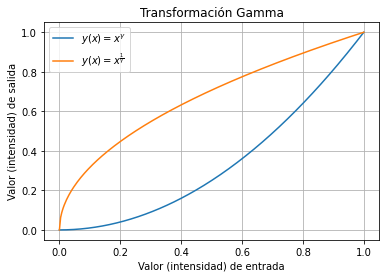

In [30]:
gamma = 2

x = np.linspace(0, 1, 256)

plt.plot(x, x**gamma, label=r'$y(x) = x^\gamma$')
plt.plot(x, x**(1/gamma), label=r'$y(x) = x^\frac{1}{\gamma}$')
plt.legend()
plt.title('Transformación Gamma')
plt.xlabel('Valor (intensidad) de entrada')
plt.ylabel('Valor (intensidad) de salida')
plt.grid()

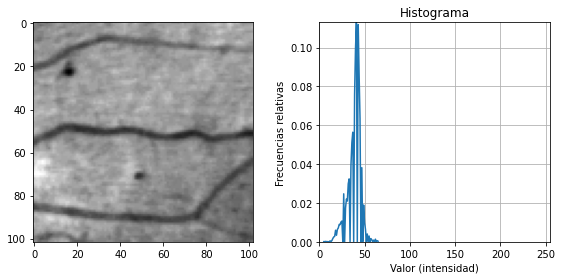

In [31]:
img_transf = exposure.adjust_gamma(img, gamma)
img_transf_hist, bins = exposure.histogram(img_transf, normalize=True)

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(img_transf, cmap='gray')

plt.subplot(122)
plt.plot(bins, img_transf_hist)
plt.axis([0,255, 0, img_transf_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

### Corrección Sigmoide

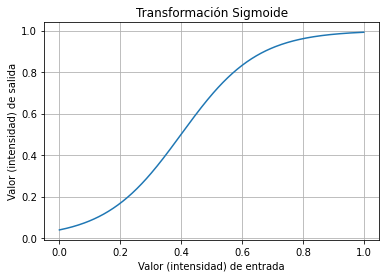

In [32]:
gain = 8
cutoff = 0.4

x = np.linspace(0, 1, 256)
y = 1/(1 + np.exp(gain*(cutoff - x)))

plt.plot(x, y)
plt.title('Transformación Sigmoide')
plt.xlabel('Valor (intensidad) de entrada')
plt.ylabel('Valor (intensidad) de salida')
plt.grid()

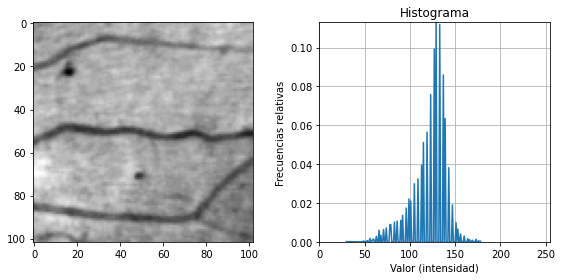

In [33]:
img = data.microaneurysms()
img_transf = exposure.adjust_sigmoid(img, cutoff, gain, inv=False)
img_transf_hist, bins = exposure.histogram(img_transf, normalize=True)

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(img_transf, cmap='gray')

plt.subplot(122)
plt.plot(bins, img_transf_hist)
plt.axis([0,255, 0, img_transf_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()

### Ecualización de histograma

Devuelve una imagen flitantre

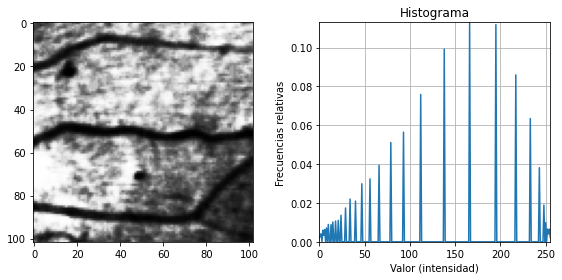

In [34]:
img = data.microaneurysms()
img_transf = util.img_as_ubyte(exposure.equalize_hist(img))
img_transf_hist, bins = exposure.histogram(img_transf, normalize=True)

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(img_transf, cmap='gray')

plt.subplot(122)
plt.plot(bins, img_transf_hist)
plt.axis([0,255, 0, img_transf_hist.max()])
plt.title('Histograma')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()

plt.tight_layout()